<a href="https://colab.research.google.com/github/NataliaKor/tutorial/blob/main/LISAsprint_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stingray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 MB 7.7 MB/s eta 0:00:00


In [2]:
import stingray.utils as stu
from stingray import Lightcurve, Crossspectrum, sampledata, Powerspectrum
from stingray.simulator import simulator, models
from stingray.fourier import poisson_level

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
import glob
import math
from scipy.signal import savgol_filter
import csv
import pandas as pd
from astropy.time import Time

In [52]:
import astropy.constants as consts
import astropy.units as u
#import scipy.constants as consts
import random

#matplotlib.rcParams['text.usetex'] = True
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
#plt.rcParams['xtick.labelsize'] = 22
#plt.rcParams['ytick.labelsize'] = 22
#plt.rcParams['lines.linewidth'] = 2


In [6]:
#%cd content
%ls

sample_data/


In [7]:
!git clone https://github.com/nbia-gwastro/binlite.git

Cloning into 'binlite'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 152 (delta 81), reused 115 (delta 44), pack-reused 0 (from 0)
Receiving objects: 100% (152/152), 6.63 MiB | 21.90 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [8]:
%cd binlite

/content/binlite


In [9]:
# Imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.colors import Colormap
from matplotlib.ticker import FormatStrFormatter, NullFormatter, MultipleLocator, MaxNLocator,ScalarFormatter

import numpy as np

import astropy.constants as consts
import astropy.units as u
#import scipy.constants as consts
import random

from binlite import AccretionSeries, BinaryAlphaDisk
from binlite.flux import periodic_flux_series, normalized_flux_series, time_from_bad, normalized_flux_series_from_bad


In [10]:
# Make the code hardware agnostic.
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch import distributions

# Making code agnostic to CPU/GPU
def std_get_wrapper(arg):
    return arg

def cuda_get_wrapper(arg):
    return arg.get()

if torch.cuda.is_available():
   import cupy as cp
   gpu = True
   get_wrapper = cuda_get_wrapper
   dev = "cuda:0"
   dtype = torch.cuda.FloatTensor
else:
   import numpy as cp
   gpu = False
   get_wrapper = std_get_wrapper
   dev = "cpu"
   dtype = torch.FloatTensor

print(gpu)

True


In [24]:
################################################################################
# Code from Scott
################################################################################

# It seems binlite uses 1000 points per orbit.

# these parameters does not matter when we normalize the flux;
fedd = 0.1
dl_pc = 1.5 * 1e9   #
obs_nu = 2.4e17     # 1 keV  in Hz

#n_lcurves = int(1e4)
n_lcurves = int(500)   # number of light curves

t_lisa = 10.*u.yr                  # full science period of LISA
#t_em_obs = 1.e6*u.s  # length of observation
t_em_obs = 80.e3*u.s  # length of observation
t_cadence = 1.e2*u.s  # spacing between data points
n_times = int( t_em_obs / t_cadence )

min_sep = 20.    # minimum separatin in r_g to consider
max_sep = 2000.  # minimum separatin in r_g to consider

lightcurves = np.ndarray((n_lcurves, n_times))
lightcurves_noise = np.ndarray((n_lcurves, n_times))

GMc2 = consts.GM_sun.cgs / consts.c.cgs**2

m_msun_pow = np.random.uniform(5.,7.,n_lcurves)
m_msuns = 10.**m_msun_pow
#sampling_parameters = m_msuns
r_g = m_msuns * GMc2

#obs_nu = vband_nu

freq_range = [1e-4,1e-1]/u.s
sep_min = (np.pi * freq_range[1] / (np.sqrt(consts.GM_sun.cgs * m_msuns)) )**(-2./3.)
sep_max = (np.pi * freq_range[0] / (np.sqrt(consts.GM_sun.cgs * m_msuns)) )**(-2./3.)
loc = (sep_min/r_g < min_sep)
sep_min[loc] = min_sep*r_g[loc]
loc = (sep_max/r_g > max_sep)
sep_max[loc] = max_sep*r_g[loc]

nbad = np.sum( sep_min > sep_max )

separation_pow = random.uniform(np.log10(sep_min[:]/r_g[:]),np.log10(sep_max[:]/r_g[:]))
separation = (10.**separation_pow) * r_g
period = (2.*np.pi*separation.cgs*np.sqrt(separation.cgs / (consts.GM_sun.cgs*m_msuns)))

sampling_parameters = period

print(f"period = {period}")
print(f"t_em_obs = {t_em_obs}")
freq = 1./period
p_yrs = (period / u.yr).cgs
n_orbits = ( (t_em_obs / period).cgs ).astype(int) + 1     # binlite requires an integer

eccs = np.random.uniform(0.0,0.8,n_lcurves)


period = [ 4574.48685064  1140.57721256   572.33497244  3235.57061433
  3076.90051143  4427.62971964 19020.02939595  1712.53588855
  9061.17447398  6055.02644641   467.66218509 24928.94454424
 11759.4465605  14088.07729181   482.86447196  1840.02439094
  3717.29334932  1343.6693959  12764.7774741  18644.80787296
  1790.19878962  8014.09672199 17140.91321091   816.14906962
 15351.16149843 19900.27929041  6454.15840275   907.27611477
  7124.52647181  3348.23165767  2660.99582665  1217.58738927
  4794.97754184  1175.99435178  5965.15814993  7712.2920665
 20832.37113899 12022.56916     5931.94387445 25199.14123598
 10484.04353452  7676.08802734  1586.07052105 10280.21091119
  1466.82145498  2044.60342589   856.41191386 12137.34906159
   445.94348116  1539.65237499  2804.03119311  1662.92089126
  1639.40640967   935.80088634   591.10048235  8930.10268295
  2619.90748056 16694.34624098  2622.41808665   657.88052688
  2859.45507026   593.61710317 17335.24317262 17963.86252399
   393.19025325 

In [16]:
print(eccs.shape)

(500,)


In [20]:
acc = AccretionSeries(eccs[3], n_modes=29, n_orbits=n_orbits[3], retrograde=False)
bad = BinaryAlphaDisk(eccs[3], p_yrs[3], m_msuns[3], dl_pc, eddington_ratio=fedd, retrograde=acc.is_retro)
yrs = time_from_bad(acc, bad)
nobs = len(yrs)
print(nobs)

14000


In [27]:
for ecc, n_orb, m_msun, p_yr, ind in zip(eccs,n_orbits,m_msuns,p_yrs,np.arange(len(eccs),dtype=int)) :
    if ind % 100 == 0:
      print('ind : {:d}'.format(ind))
    #print('ecc : {:.2f}'.format(ecc))
    acc = AccretionSeries(ecc, n_modes=29, n_orbits=n_orb, retrograde=False)
    bad = BinaryAlphaDisk(ecc, p_yr, m_msun, dl_pc, eddington_ratio=fedd, retrograde=acc.is_retro)
    yrs = time_from_bad(acc, bad)
    flux = normalized_flux_series_from_bad(obs_nu, acc, bad)
    secs = np.array(yrs*365.*24.*3600.)

    # simulate red noise
    #nobs = len(yrs)
    sim = simulator.Simulator(N=n_times, mean=100, rms=0.2, dt=20, random_state = 100, poisson=False)
    sim_pois = simulator.Simulator(N=n_times, mean=100, rms=0.2, dt=20, random_state = 200, poisson=True)

    lc_pois = sim_pois.simulate(2)

    time = lc_pois.time
    cts = lc_pois.smooth_counts

    # rand_start = np.random.randint(1000, high=5000)
    rand_start = 0

    x_rn = time[rand_start:rand_start+n_times]-time[rand_start]
    y_rn = cts[rand_start:rand_start+n_times]
    x_flux = secs[0:n_times]
    y_flux = flux[0:n_times]

    y_rn_norm = (y_rn-np.mean(y_rn))/np.std(y_rn)*np.std(y_flux)
    obsflux = y_flux + y_rn_norm
    lightcurves[ind,:] = obsflux[0:n_times]
    lightcurves_noise[ind,:] = y_rn_norm[0:n_times]

ind : 0
ind : 100
ind : 200
ind : 300
ind : 400


In [23]:
print(x_flux.shape)

(12000,)


In [28]:
from cuml.manifold import TSNE

In [46]:
lightcurves_both = np.vstack([lightcurves, lightcurves_noise])
print(lightcurves_both.shape)
y = np.hstack([np.ones(lightcurves.shape[0]), np.zeros(lightcurves.shape[0])])
print(y.shape)

(1000, 800)
(1000,)


In [47]:
tsne = TSNE(n_components = 2)
lc_tsne = tsne.fit_transform(lightcurves_both)

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:405: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


In [48]:
print(lc_tsne.shape)
print(y.shape)

(1000, 2)
(1000,)


In [51]:
print(lc_tsne[:,0])

[ 8.20358753e+00 -1.85222893e+01  1.21712999e+01  5.34645796e+00
 -1.85351028e+01 -5.13079214e+00  3.96816597e+01  1.25672865e+01
  9.23835373e+00  2.56582336e+01  5.69023132e+00  3.36231804e+01
  1.29708099e+01  6.47815561e+00 -2.07435150e+01 -3.04567394e+01
  7.74193716e+00  1.78675127e+00 -5.81241369e+00  1.61117973e+01
 -1.22106962e+01  3.05339756e+01 -3.40784569e+01  3.49641151e+01
  3.03776321e+01  2.94093037e+01  2.07602673e+01 -2.20577259e+01
  1.13369246e+01  1.58004408e+01  6.44243622e+00 -1.68064194e+01
  9.03233051e+00 -1.74194031e+01 -1.97954063e+01  8.70354557e+00
 -7.04995441e+00  2.86210022e+01  5.69696045e+00 -1.26245861e+01
 -2.63620739e+01  6.36261511e+00 -1.52513485e+01 -3.36422577e+01
  3.68646115e-01  1.32197819e+01 -6.49280691e+00  3.78502884e+01
 -1.54892626e+01  5.90734434e+00  2.71975079e+01 -3.08317814e+01
  3.29421387e+01  9.32156181e+00  1.49003476e-01 -2.07187920e+01
  5.01825380e+00 -1.62545471e+01  3.07969437e+01  2.42750502e+00
  6.38253641e+00  4.03935

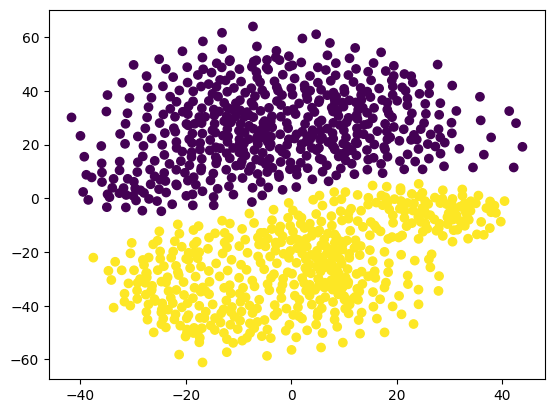

In [57]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

plt.scatter(lc_tsne[:,0], lc_tsne[:,1],c=y)
plt.show()